# Online Gaming Behavior EDA:
## Technical Modeling (This is an experimental notebook)

dataset: [Kaggle](https://www.kaggle.com/datasets/rabieelkharoua/predict-online-gaming-behavior-dataset/data)

____

In the descriptive and inferential analysis notebook, the findings were a bit simple. The data was very clean and after running a bunch of questions through the ringer, it seems like those who catered this dataset did a great job finding pretty great samples for each section. Main areas that showed a different were when males and females were taken into account. Mostly, as the sterotype goes, males play more games. However, there wasn't an insane disparity with the numbers, probably close to 3 to 2 ratio. 

The inferential section didn't find any significant impacts on the data, at least for the questions I posed. I hope that means I missed something in the initial findings, and I will be able to come up with a model that has a solid accuracy rating for predictions. Given this data set is focused on online behavior in the sense of engagement level, we will focus on that as our target variable. I will look at making some dummy data out of some of the categorical features and move to scale our data to be a bit more understandable in terms of correlations. 

In [1]:
# Standard Data Science/Analysis Toolkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns

# Machine Learning Tools, Utilities, and Scoring Metrics
from sklearn.preprocessing import StandardScaler, label_binarize, PolynomialFeatures

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline

# Suite of Machine Learning Algorithms
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/online_gaming_behavior.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

We will perform some of the data cleaning from the previous notebook. This is all the same, so please see descriptive analysis for reasoning

In [3]:
df = df.drop(['PlayerID', 'PlayerLevel', 'AchievementsUnlocked'], axis=1)
df = df.rename(columns={'Gender': 'Sex'})
# df['AgeCategory'] = pd.cut(df['Age'], [15, 24, 34, 44, 49], labels=['15-24', '25-34', '35-44', '45+'], include_lowest=True)

In [4]:
df.head(5)

,Age,Sex,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,EngagementLevel
0,43,Male,Other,Strategy,16.271119,0,Medium,6,108,Medium
1,29,Female,USA,Strategy,5.525961,0,Medium,5,144,Medium
2,22,Female,USA,Sports,8.223755,0,Easy,16,142,High
3,35,Male,USA,Action,5.265351,1,Easy,9,85,Medium
4,33,Male,Europe,Action,15.531945,0,Medium,2,131,Medium


We are using EngagementLevel as our target, and we will start with all the other columns as our features. We can tweak after our shotgun of tests.

In [5]:
df = pd.get_dummies(df, columns=['Sex', 'Location', 'GameGenre', 'GameDifficulty'], drop_first=True)
# The drop_first=True parameter avoids multicollinearity by dropping the first category in each variable
df

,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,EngagementLevel,Sex_Male,Location_Europe,Location_Other,Location_USA,GameGenre_RPG,GameGenre_Simulation,GameGenre_Sports,GameGenre_Strategy,GameDifficulty_Hard,GameDifficulty_Medium
0,43,16.271119,0,6,108,Medium,1,0,1,0,0,0,0,1,0,1
1,29,5.525961,0,5,144,Medium,0,0,0,1,0,0,0,1,0,1
2,22,8.223755,0,16,142,High,0,0,0,1,0,0,1,0,0,0
3,35,5.265351,1,9,85,Medium,1,0,0,1,0,0,0,0,0,0
4,33,15.531945,0,2,131,Medium,1,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40029,32,20.619662,0,4,75,Medium,1,0,0,1,0,0,0,1,0,0
40030,44,13.539280,0,19,114,High,0,0,1,0,0,1,0,0,1,0
40031,15,0.240057,1,10,176,High,0,0,0,1,1,0,0,0,0,0
40032,34,14.017818,1,3,128,Medium,1,0,0,1,0,0,1,0,0,1


____

### Trying something new

I want to add PolynomialFeatures this time around with 4 of the continuous data features, and then add that to the data set. 


In [6]:
# Initialize PolynomialFeatures with degree 3 (you can change the degree as needed)
poly = PolynomialFeatures(degree=3, include_bias=False)

# Fit and transform the data
poly_features = poly.fit_transform(df[['Age', 'PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes']])

# Convert the output to a DataFrame with appropriate feature names
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names(['Age', 'PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes']))

df_with_poly = pd.concat([df, poly_df], axis=1)

In [7]:
df_with_poly

,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,EngagementLevel,Sex_Male,Location_Europe,Location_Other,Location_USA,...,PlayTimeHours^3,PlayTimeHours^2 SessionsPerWeek,PlayTimeHours^2 AvgSessionDurationMinutes,PlayTimeHours SessionsPerWeek^2,PlayTimeHours SessionsPerWeek AvgSessionDurationMinutes,PlayTimeHours AvgSessionDurationMinutes^2,SessionsPerWeek^3,SessionsPerWeek^2 AvgSessionDurationMinutes,SessionsPerWeek AvgSessionDurationMinutes^2,AvgSessionDurationMinutes^3
0,43,16.271119,0,6,108,Medium,1,0,1,0,...,4307.767395,1588.495834,28592.925018,585.760275,10543.684957,189786.329223,216.0,3888.0,69984.0,1259712.0
1,29,5.525961,0,5,144,Medium,0,0,0,1,...,168.742134,152.681246,4397.219882,138.149035,3978.692194,114586.335188,125.0,3600.0,103680.0,2985984.0
2,22,8.223755,0,16,142,High,0,0,0,1,...,556.173803,1082.082405,9603.481343,2105.281342,18684.371913,165823.800730,4096.0,36352.0,322624.0,2863288.0
3,35,5.265351,1,9,85,Medium,1,0,0,1,...,145.976199,249.515317,2356.533546,426.493453,4027.993727,38042.162979,729.0,6885.0,65025.0,614125.0
4,33,15.531945,0,2,131,Medium,1,1,0,0,...,3746.946497,482.482601,31602.610380,62.127778,4069.369465,266543.699927,8.0,524.0,34322.0,2248091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40029,32,20.619662,0,4,75,Medium,1,0,0,1,...,8766.871736,1700.681913,31887.785878,329.914599,6185.898726,115985.601120,64.0,1200.0,22500.0,421875.0
40030,44,13.539280,0,19,114,High,0,0,1,0,...,2481.914144,3482.930194,20897.581165,4887.680247,29326.081485,175956.488909,6859.0,41154.0,246924.0,1481544.0
40031,15,0.240057,1,10,176,High,0,0,0,1,...,0.013834,0.576273,10.142406,24.005688,422.500111,7436.001951,1000.0,17600.0,309760.0,5451776.0
40032,34,14.017818,1,3,128,Medium,1,0,0,1,...,2754.490311,589.497663,25151.900270,126.160362,5382.842103,229667.929747,27.0,1152.0,49152.0,2097152.0


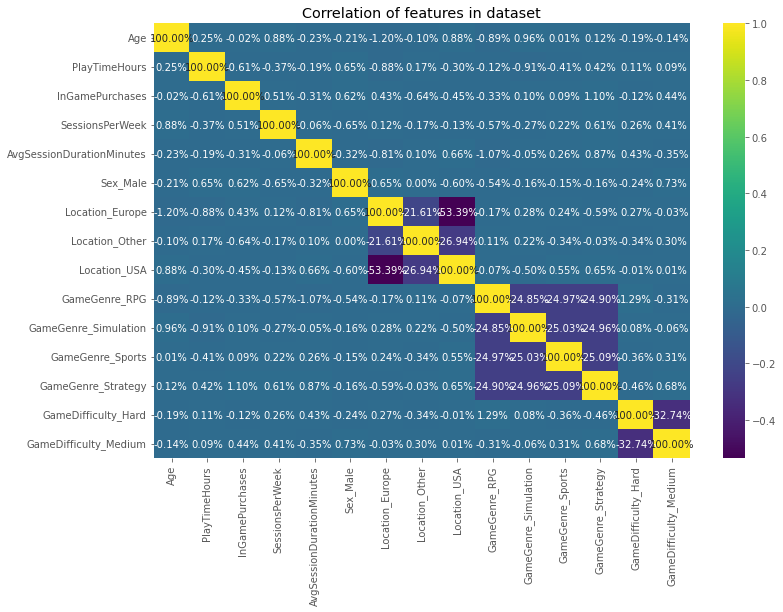

In [8]:
# Create the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(df.corr(method='pearson'), annot=True, cmap='viridis', fmt='.2%')

# Set title
plt.title('Correlation of features in dataset')

#show the plot
plt.show()

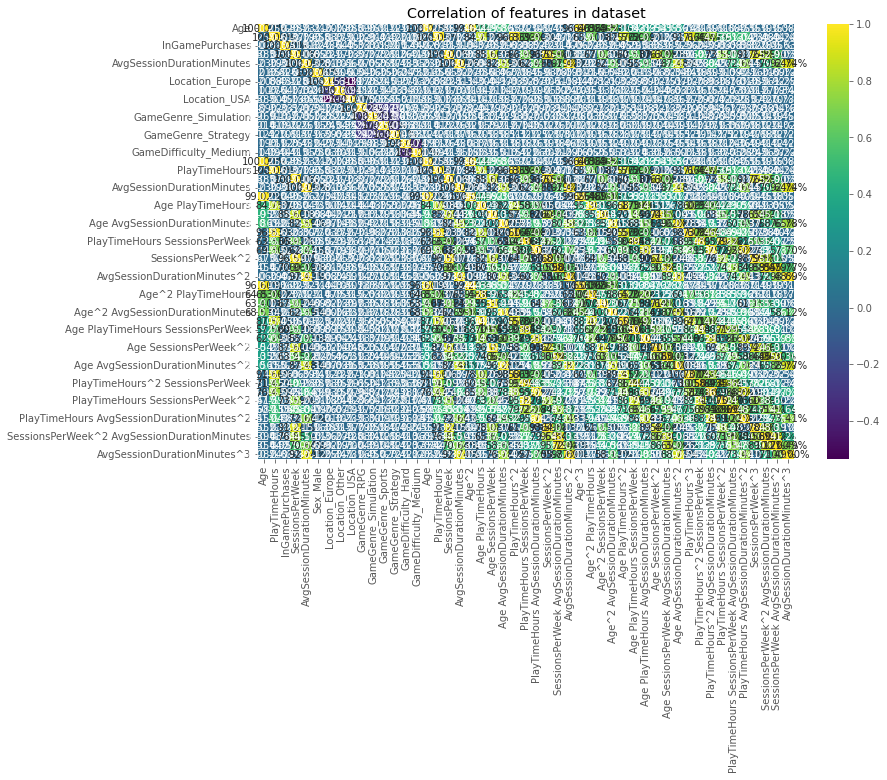

In [9]:
# Create the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(df_with_poly.corr(method='pearson'), annot=True, cmap='viridis', fmt='.2%')

# Set title
plt.title('Correlation of features in dataset')

#show the plot
plt.show()

As compared to our descriptive section in the other notebook, the features here seem to be having a bigger impact on one another, though it looks like a lot of negative values. We also turned categorical data into numerical, so now we can actually see how Age and Sex compare.

In [10]:
X = df_with_poly.drop('EngagementLevel', axis=1)
y = df_with_poly['EngagementLevel']

In [11]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# 1. Logistic Regression
# Chosen because it's a simple and interpretable linear model, good for baseline performance.
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.7290816751311298


In [13]:
# 2. Random Forest Classifier
# Selected as it’s an ensemble method, combining multiple decision trees to improve accuracy and reduce overfitting.
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.8793605861293814


In [14]:
# 3. Support Vector Machine (SVM)
# SVM is powerful for high-dimensional spaces and is effective when the number of dimensions is greater than the number of samples.
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

SVM Accuracy: 0.8091749229872617


In [15]:
# 4. K-Nearest Neighbors (KNN)
# KNN is a simple, instance-based learning method that works well for smaller datasets.
knn = KNN()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

KNN Accuracy: 0.8259928398967613


In [16]:
# 5. Gaussian Naive Bayes
# Naive Bayes is fast, and performs well on small datasets with categorical features.
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.7005245191907418


In [17]:
# 6. Decision Tree Classifier
# Decision Trees are easy to interpret and can handle both numerical and categorical data.
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))

Decision Tree Accuracy: 0.7972691699275664


In [18]:
# 7. Gradient Boosting Classifier
# Gradient Boosting is another ensemble method like Random Forest, but it builds trees sequentially to reduce errors.
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.8845225210223961


In [19]:
# Display classification reports
print("\nClassification Report for Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("----------------------------------------\n")
print("\nClassification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))
print("----------------------------------------\n")
print("\nClassification Report for SVM:\n", classification_report(y_test, y_pred_svm))
print("----------------------------------------\n")
print("\nClassification Report for KNN:\n", classification_report(y_test, y_pred_knn))
print("----------------------------------------\n")
print("\nClassification Report for Gaussian Naive Bayes:\n", classification_report(y_test, y_pred_nb))
print("----------------------------------------\n")
print("\nClassification Report for Decision Tree Classifier:\n", classification_report(y_test, y_pred_dt))
print("----------------------------------------\n")
print("\nClassification Report for Gradient Booster Classifier:\n", classification_report(y_test, y_pred_gb))


Classification Report for Logistic Regression:
               precision    recall  f1-score   support

        High       0.69      0.76      0.73      3132
         Low       0.81      0.61      0.69      3069
      Medium       0.72      0.78      0.75      5810

    accuracy                           0.73     12011
   macro avg       0.74      0.72      0.72     12011
weighted avg       0.74      0.73      0.73     12011

----------------------------------------


Classification Report for Random Forest:
               precision    recall  f1-score   support

        High       0.91      0.87      0.89      3132
         Low       0.84      0.85      0.84      3069
      Medium       0.88      0.90      0.89      5810

    accuracy                           0.88     12011
   macro avg       0.88      0.87      0.87     12011
weighted avg       0.88      0.88      0.88     12011

----------------------------------------


Classification Report for SVM:
               precision    re

We completed a shotgun approach to modeling at the start. This was useful, because we could just run all the base level tests we want, and see which stands out above the rest. Random Forest, SVM, and Gradient Booster all seem to have promising starts.

Before we select a model to dig deeper into, let's run a pipeline that scales the data first and then runs the prediction tests. We run these through pipelines to make sure all processes are completed in the proper order, and also to avoid data leakage. 

In [20]:
# Create pipelines for each classifier with StandardScaler
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression())
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier())
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC())
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNN())
    ]),
    'Naive Bayes': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', GaussianNB())
    ]),
    'Decision Tree': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier())
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', GradientBoostingClassifier())
    ])
}

In [21]:
model_accuracies = {}
# Train and evaluate each pipeline
for name, pipeline in pipelines.items():
    print(f"\n{name} Pipeline Results:")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    model_accuracies[name] = {'accuracy': accuracy, 'report': report}
    print(f"Accuracy: {accuracy:.4f}")
    # print(f"Classification Report:\n{classification_report(y_test, y_pred)}")



Logistic Regression Pipeline Results:
Accuracy: 0.8736

Random Forest Pipeline Results:
Accuracy: 0.8802

SVM Pipeline Results:
Accuracy: 0.8734

KNN Pipeline Results:
Accuracy: 0.7996

Naive Bayes Pipeline Results:
Accuracy: 0.7130

Decision Tree Pipeline Results:
Accuracy: 0.7967

Gradient Boosting Pipeline Results:
Accuracy: 0.8842


In [22]:
# Find the model with the highest accuracy
best_model = max(model_accuracies, key=lambda x: model_accuracies[x]['accuracy'])
best_accuracy = model_accuracies[best_model]['accuracy']
best_report = model_accuracies[best_model]['report']


# Print the model with the highest accuracy and its accuracy
print(f"\nBest Model: {best_model} with Accuracy: {best_accuracy:.4f}")
print(f'Classification Report: \n{best_report}')


Best Model: Gradient Boosting with Accuracy: 0.8842
Classification Report: 
              precision    recall  f1-score   support

        High       0.92      0.87      0.89      3132
         Low       0.84      0.86      0.85      3069
      Medium       0.89      0.91      0.90      5810

    accuracy                           0.88     12011
   macro avg       0.88      0.88      0.88     12011
weighted avg       0.88      0.88      0.88     12011



Most models came to very similiar if not the same accuracy. Logistic Regression and KNN had big swings, where LR improved in accuracy and KNN decreased. I suppose that is because I created dummy data for the categorical features that improved LR, but that also created more data so KNN worsened. 

We are going focus on tuning the Gradient Boosting model to see if we can get a better accuracy.

In [23]:
# # Define the parameter grid
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 500],
#     'max_depth': [3, 5, 7],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'subsample': [0.8, 1.0]
# }

# # Initialize the model
# gb = GradientBoostingClassifier(random_state=42)

# # Grid Search or Randomized Search
# grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print(f"Best parameters found: {best_params}")

Image below of the test that was run above, to save on load time of this notebook.

![70 minutes of running a model results](model_run_images/gradient_boosting_grid_search_486x5.png "Best parameters found")

Best parameters found from above: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500, 'subsample': 0.8}

In [24]:
# # Evaluate the best model on the test set
# best_model = grid_search.best_estimator_
# test_accuracy = best_model.score(X_test, y_test)
# print(f"Test set accuracy: {test_accuracy:.4f}")

Before Gridsearch we attained Best Model: Gradient Boosting with Accuracy: 0.8786\
After 70 mins of GridSearchCV we Test set accuracy: 0.8814

In [25]:
param_grid = {'learning_rate': [0.01],
              'max_depth': [5],
              'min_samples_leaf': [4],
              'min_samples_split': [2],
              'n_estimators': [500],
              'subsample': [0.8]}

# Initialize the model
gb = GradientBoostingClassifier(random_state=42)

# Grid Search
best_grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
best_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.7min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.7min finished


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [5],
                         'min_samples_leaf': [4], 'min_samples_split': [2],
                         'n_estimators': [500], 'subsample': [0.8]},
             scoring='accuracy', verbose=2)

In [26]:
# Can change the following to grid_search if running model for the first time
best_score = best_grid_search.best_score_
print(f"Best cross-validated score: {best_score:.4f}")

Best cross-validated score: 0.8846


In [27]:
# Can change the following to grid_search if running model for the first time
best_estimator = best_grid_search.best_estimator_
print(f"Best estimator:\n{best_estimator}")

Best estimator:
GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=4,
                           n_estimators=500, random_state=42, subsample=0.8)


In [28]:
# Can change the following to grid_search if running model for the first time
cv_results = pd.DataFrame(best_grid_search.cv_results_)
print("CV Results Summary:")
print(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

CV Results Summary:
                                              params  mean_test_score  \
0  {'learning_rate': 0.01, 'max_depth': 5, 'min_s...          0.88463   

   std_test_score  rank_test_score  
0        0.005026                1  


In [29]:
# Sort by rank to see the top combinations
# This would matter more when first running our model.
top_results = cv_results.sort_values(by='rank_test_score').head(10)
print("Top 10 parameter combinations:")
print(top_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

Top 10 parameter combinations:
                                              params  mean_test_score  \
0  {'learning_rate': 0.01, 'max_depth': 5, 'min_s...          0.88463   

   std_test_score  rank_test_score  
0        0.005026                1  


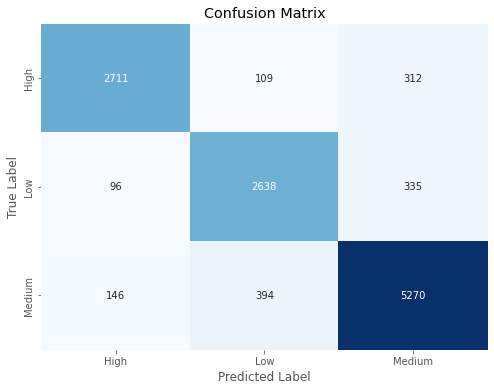

In [30]:
# Predict labels
y_pred = best_grid_search.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=best_grid_search.classes_, yticklabels=best_grid_search.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Generate classification report
report = classification_report(y_test, y_pred, target_names=best_grid_search.classes_)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

        High       0.92      0.87      0.89      3132
         Low       0.84      0.86      0.85      3069
      Medium       0.89      0.91      0.90      5810

    accuracy                           0.88     12011
   macro avg       0.88      0.88      0.88     12011
weighted avg       0.88      0.88      0.88     12011



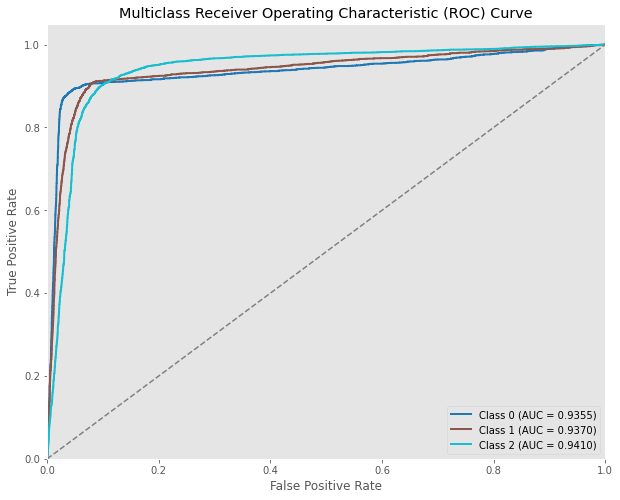

In [32]:
# Binarize the labels for each class
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Predict probabilities for each class
y_prob = best_grid_search.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, 
             label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

It seems like we have captured most of the data represented. 

___

## Summary

___

For this technical modeling, I wanted to take a widespread approach and then narrow down my focus. I ran a quick cleaning of the data as I did in the previous notebook with a few alterations. I also created dummy columns for the categorical features to be able to scale them better. Once the data was cleaned it was time to run through a smörgåsbord of models. 

Since our target is categorical "EngagementLevel" the focus would be on classification models. To get as best of a spread of models we employed 7 models: Logistic Regression, Random Forest, SVM, KNN, Naive Bayes, Decision Tree, and Gradient Boosting. After the first round, Gradient Boosting, Random Forest, and SVM came out on top as the most accurate.

I made sure to rerun them all using a Pipeline and invoking StandardScaler. Doing this helped to work around data leakage. I got close the same results on the main 3 noted above. I decided that I would just go with the highest accuracy score and that was Gradient Boosting.

Once locked in, I employed a longer model run using a large parameter grid, for GridSearchCV and a decent number of cross evaluations. I was able to go from 87.86% to 88.14% accuracy rating.

This would be the area to continuing find tuning, and will do so in the future. 

____

## Recommendations

____

Given the accuracy of this model, I believe it's safe to say that we can predict how the features selected will impact engagement level for online gaming. 

While equity in gaming has been a big push for the recent decade or so, this data shows a solid amount of female gamers in most areas, with a pretty steady ratio of about ~1.5 to males. There's not much significant difference in how the different features of this dataset were impacted given males vs. females. 

1. The data found that Easy difficulty games were the most prevelant. This would be a good area to focus on increasing those types of games to the market. 

2. Engagement Level was favored in the medium category. That's a good place to have the majority of players fall, but we can push that harder to get longer engagement. 

3. Continue to focus on females in the market place, because it's working. We can get that ratio closer to 1.0 within the decade. 